# Download Dataset

In [1]:
!gdown --id 1qkDROc7JhadK2K0cJFdNm9tpuDtEbl_- --output hw3_data.zip
!unzip -q hw3_data.zip
!rm hw3_data.zip

Downloading...
From: https://drive.google.com/uc?id=1qkDROc7JhadK2K0cJFdNm9tpuDtEbl_-
To: /content/hw3_data.zip
100% 547M/547M [00:04<00:00, 134MB/s]


# Import Packages

In [2]:
import numpy as np
import glob
import os
import random
import torch
import torch.nn as nn
import torchvision
from PIL import Image
from torch.utils import data
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
import torchvision.models as models

# Set Random Seed

In [3]:
def fix_random_seeds(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.enabled = False

# Get Dataset

In [4]:
class image_dataset(data.Dataset):
    def __init__(self, input_paths: list, transforms):
      self.input_paths = input_paths
      self.transforms = transforms

    def __len__(self):
      return len(self.input_paths)

    def __getitem__(self, index: int):
      input_path = self.input_paths[index]
      img = Image.open(input_path).convert('RGB')
      return self.transforms(img)

def get_testing_dataset(path, batch_size, n_workers, image_size):
    test_transforms = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    ])
    
    test_path = os.path.join(path, '*')
    test_fns = glob.glob(test_path)
    test_set = image_dataset(test_fns, test_transforms, 'val')
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

    return test_loader

In [ ]:
img = Image.open('./hw3_data/p2_data/images/bike.jpg')
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])
img = test_transforms(img)

In [25]:
!git clone https://github.com/saahiluppal/catr.git

Cloning into 'catr'...
remote: Enumerating objects: 121, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 121 (delta 55), reused 74 (delta 27), pack-reused 0
Receiving objects: 100% (121/121), 3.05 MiB | 17.74 MiB/s, done.
Resolving deltas: 100% (55/55), done.


In [32]:
%cd catr

/content/catr


In [27]:
!pip install -r ./requirements.txt

In [35]:
!python predict.py --path ../hw3_data/p2_data/images/ski.jpg

Using cache found in /root/.cache/torch/hub/saahiluppal_catr_master
/content/catr/models/position_encoding.py:38: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)
/content/catr/models/position_encoding.py:38: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.tem

In [37]:
%cd ..

/content


In [5]:
from typing import List, Optional

import torch
import torch.distributed as dist
from torch import Tensor
def _max_by_axis(the_list):
    # type: (List[List[int]]) -> List[int]
    maxes = the_list[0]
    for sublist in the_list[1:]:
        for index, item in enumerate(sublist):
            maxes[index] = max(maxes[index], item)
    return maxes


def nested_tensor_from_tensor_list(tensor_list: List[Tensor]):
    # TODO make this more general
    if tensor_list[0].ndim == 3:
        # TODO make it support different-sized images
        max_size = _max_by_axis([list(img.shape) for img in tensor_list])
        # min_size = tuple(min(s) for s in zip(*[img.shape for img in tensor_list]))
        batch_shape = [len(tensor_list)] + max_size
        # get maximum size of image in tensor_list
        b, c, h, w = batch_shape
        dtype = tensor_list[0].dtype
        device = tensor_list[0].device
        tensor = torch.zeros(batch_shape, dtype=dtype, device=device)
        mask = torch.ones((b, h, w), dtype=torch.bool, device=device)
        for img, pad_img, m in zip(tensor_list, tensor, mask):
            pad_img[: img.shape[0], : img.shape[1], : img.shape[2]].copy_(img)
            m[: img.shape[1], :img.shape[2]] = False
    else:
        raise ValueError('not supported')
    return NestedTensor(tensor, mask)


class NestedTensor(object):
    def __init__(self, tensors, mask: Optional[Tensor]):
        self.tensors = tensors
        self.mask = mask

    def to(self, device):
        # type: (Device) -> NestedTensor # noqa
        cast_tensor = self.tensors.to(device)
        mask = self.mask
        if mask is not None:
            assert mask is not None
            cast_mask = mask.to(device)
        else:
            cast_mask = None
        return NestedTensor(cast_tensor, cast_mask)

    def decompose(self):
        return self.tensors, self.mask

    def __repr__(self):
        return str(self.tensors)

def generate_square_subsequent_mask(sz):
    r"""Generate a square mask for the sequence. The masked positions are filled with float('-inf').
        Unmasked positions are filled with float(0.0).
    """
    mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float(
        '-inf')).masked_fill(mask == 1, float(0.0))
    return mask

In [7]:
!pip install transformers

     |████████████████████████████████| 3.3 MB 5.2 MB/s 
     |████████████████████████████████| 895 kB 48.8 MB/s 
     |████████████████████████████████| 3.3 MB 24.3 MB/s 
     |████████████████████████████████| 596 kB 70.2 MB/s 
     |████████████████████████████████| 61 kB 502 kB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [119]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from transformers import BertTokenizer
from PIL import Image
from torchvision.transforms import transforms

model = torch.hub.load('saahiluppal/catr', 'v3', pretrained=True)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

start_token = tokenizer.convert_tokens_to_ids(tokenizer._cls_token)
# start_token = 101
end_token = tokenizer.convert_tokens_to_ids(tokenizer._sep_token)
# end_token = 102

MAX_DIM = 299
max_position_embeddings = 128

# resize the longer side of image to 299
def under_max(image):
    if image.mode != 'RGB':
        image = image.convert("RGB")

    shape = np.array(image.size, dtype=np.float)
    long_dim = max(shape)
    scale = MAX_DIM / long_dim

    new_shape = (shape * scale).astype(int)
    image = image.resize(new_shape)

    return image

val_transform = transforms.Compose([
    transforms.Lambda(under_max),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

image_path = './hw3_data/p2_data/images/girl.jpg'
image = Image.open(image_path)
image = val_transform(image)
image = image.unsqueeze(0)
# image.size = (1, C, H, W)


def create_caption_and_mask(start_token, max_length):
    caption_template = torch.zeros((1, max_length), dtype=torch.long)
    mask_template = torch.ones((1, max_length), dtype=torch.bool)

    caption_template[:, 0] = start_token
    mask_template[:, 0] = False

    return caption_template, mask_template

caption, cap_mask = create_caption_and_mask(
    start_token, max_position_embeddings)


@torch.no_grad()
def evaluate():
    model.eval()
    count_str = 0
    for i in range(max_position_embeddings - 1):
        predictions = model(image, caption, cap_mask)
        # predictions.shape = [1, 128, 30522]
        predictions = predictions[:, i, :]
        predicted_id = torch.argmax(predictions, axis=-1)
        count_str += 1

        if predicted_id[0] == 102:
            return caption, cap_mask, count_str

        caption[:, i+1] = predicted_id[0]
        cap_mask[:, i+1] = False

    return caption, cap_mask, count_str


output, tgt_mask, count_str = evaluate()
result = tokenizer.decode(output[0].tolist(), skip_special_tokens=True)
print(result.capitalize())

Using cache found in /root/.cache/torch/hub/saahiluppal_catr_master
/root/.cache/torch/hub/saahiluppal_catr_master/models/position_encoding.py:38: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)


A young girl holding a slice of pizza in her hands.


/root/.cache/torch/hub/saahiluppal_catr_master/models/position_encoding.py:38: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)


(h, w) = ((13, 19))
A young girl holding a slice of pizza in her hands.


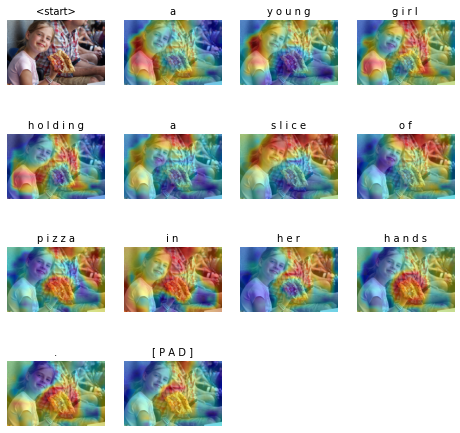

In [133]:
def generate(image, output, tgt_mask):
    tokens = output
    # -------------------------- caption --------------------------
    if not isinstance(image, NestedTensor):
      image = nested_tensor_from_tensor_list(image)

    features, pos = model.backbone(image)
    src, mask = features[-1].decompose()

    src = model.input_proj(src)
    # -------------------------- transformer --------------------------
    pos_embed, tgt = pos[-1], output

    bs, c, h, w = src.shape
    print(f'(h, w) = ({h, w})')
    src = src.flatten(2).permute(2, 0, 1)
    pos_embed = pos[-1].flatten(2).permute(2, 0, 1)
    mask = mask.flatten(1)

    tgt = model.transformer.embeddings(tgt).permute(1, 0, 2)
    query_embed = model.transformer.embeddings.position_embeddings.weight.unsqueeze(1)
    query_embed = query_embed.repeat(1, bs, 1)
    memory = model.transformer.encoder(src, src_key_padding_mask=mask, pos=pos_embed)
    # -------------------------- decoder --------------------------
    memory_mask, tgt_key_padding_mask, memory_key_padding_mask, pos, query_pos = None, tgt_mask, mask, pos_embed, query_embed
    tgt_mask = generate_square_subsequent_mask(len(tgt)).to(tgt.device)

    output = tgt
    for i in range(len(model.transformer.decoder.layers) - 1):
        output = model.transformer.decoder.layers[i](output, memory, tgt_mask=tgt_mask,
                        memory_mask=memory_mask,
                        tgt_key_padding_mask=tgt_key_padding_mask,
                        memory_key_padding_mask=memory_key_padding_mask,
                        pos=pos, query_pos=query_pos)

    # -------------------------- decoderlayer --------------------------
    # def forward_pre(self, tgt, memory,
    #                     tgt_mask: Optional[Tensor] = None,
    #                     memory_mask: Optional[Tensor] = None,
    #                     tgt_key_padding_mask: Optional[Tensor] = None,
    #                     memory_key_padding_mask: Optional[Tensor] = None,
    #                     pos: Optional[Tensor] = None,
    #                     query_pos: Optional[Tensor] = None):
    tgt = output

    tgt2 = model.transformer.decoder.layers[-1].norm1(tgt)
    q = k = model.transformer.decoder.layers[-1].with_pos_embed(tgt2, query_pos)
    tgt2 = model.transformer.decoder.layers[-1].self_attn(q, k, value=tgt2, attn_mask=tgt_mask,
                          key_padding_mask=tgt_key_padding_mask)[0]
    # tgt = tgt + model.transformer.decoder.layers[-1].dropout1(tgt2)
    tgt2 = model.transformer.decoder.layers[-1].norm2(tgt)

    use_q = model.transformer.decoder.layers[-1].with_pos_embed(tgt2, query_pos).squeeze()
    use_k = model.transformer.decoder.layers[-1].with_pos_embed(memory, pos).squeeze()

    attn_matrix = use_q @ use_k.T
    plt.figure(figsize=(8, 8))
    plt.subplot(count_str // 4 + 1, 4, 1)
    plt.imshow(Image.open(image_path))
    plt.axis('off')
    plt.title('<start>', fontsize=10)
    plt.grid('on')
    for i in range(count_str):
        attn_heatmap = attn_matrix[i].reshape(h, w).detach().cpu().numpy()

        attn_heatmap -= np.min(attn_heatmap)
        attn_heatmap /= np.max(attn_heatmap)

        img = cv2.imread(image_path)
        heatmap = cv2.resize(attn_heatmap, (img.shape[1], img.shape[0]))
        heatmap = np.uint8(255 * heatmap)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
        alpha = 0.4
        gamma = 0
        superimposed_img = cv2.addWeighted(heatmap, alpha, img, 1 - alpha, gamma)
        # superimposed_img = np.array([superimposed_img[:, :, 2], superimposed_img[:, :, 1], superimposed_img[:, :, 0]])
        superimposed_img = superimposed_img[:, :, ::-1]
        # superimposed_img = np.moveaxis(superimposed_img, [2, 0, 1], [0, 1, 2])
        # superimposed_img = heatmap * 0.4

        plt.subplot(count_str // 4 + 1, 4, i + 2)
        # plt.plot(superimposed_img)
        plt.imshow(superimposed_img)
        plt.title(f'{tokenizer.decode(tokens[0].tolist()[i + 1], skip_special_tokens=True)}', fontsize=10)
        plt.axis('off')
        plt.grid('on')
        # cv2.imwrite(f'./map{i + 1}.jpg', superimposed_img)
        # cv2.imshow('image', superimposed_img)
        if caption[0, i] == 1012:
            break
generate(image, output, tgt_mask)
plt.savefig(f'{image_path.split("/")[-1].split(".")[0]}.png')
# plt.show()
print(result.capitalize())

In [3]:
!pip install transformers
!python hw3_2.py --test_repo ./hw3_data/p2_data/images --output_repo .

     |████████████████████████████████| 3.3 MB 5.8 MB/s 
     |████████████████████████████████| 3.3 MB 40.3 MB/s 
     |████████████████████████████████| 61 kB 406 kB/s 
     |████████████████████████████████| 895 kB 52.8 MB/s 
     |████████████████████████████████| 596 kB 35.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Downloading: "https://github.com/saahiluppal/catr/archive/master.zip" to /root/.cache/torch/hub/master.zip
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100% 171M/171M [00:04<00:00, 41.4MB/s]
Downloading: "https://github.com/saahiluppal/catr/releases/download/0.2/weight493084032.pth" to /root/.cache/torch/hub/checkpoints/weight493084032.pth
100% 322M/322M [00:04<00:00, 81.8MB/s]
Downloading: 100% 226k/226k [00:00<00:00, 2.90MB/s]
Downloading: 100% 28.0/28.0 [00:00<00:00,